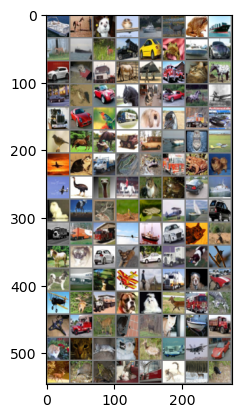

ship  horse dog   bird  ship  deer  frog  ship  deer  ship  deer  truck car   frog  ship  car   car   dog   truck horse plane truck cat   horse car   bird  car   horse dog   car   horse plane truck car   bird  truck dog   bird  truck car   bird  horse horse truck car   ship  ship  plane plane cat   truck frog  frog  truck frog  dog   plane bird  bird  horse cat   frog  car   ship  cat   bird  deer  bird  frog  plane ship  car   truck truck truck bird  ship  car   cat   deer  horse dog   car   dog   car   truck dog   bird  dog   plane deer  plane horse truck dog   car   plane deer  truck dog   dog   deer  truck cat   plane truck deer  cat   deer  cat   ship  truck cat   cat   cat   dog   deer  plane plane car   deer  bird  frog  cat   truck cat   deer  bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# functions to show an image
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [3]:
# initialize the network
import torch.nn as nn
import torch.nn.functional as F
import torch

# --- 1. 定义核心：基础残差块 (BasicBlock) ---
class BasicBlock(nn.Module):
    """
    ResNet的基本残差块，适用于ResNet-18/34 (使用两个3x3卷积层)
    """
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        
        # 第一个卷积层: 负责降维/改变特征图大小 (如果 stride > 1)
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        # 第二个卷积层: 保持尺寸不变
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 定义快捷连接 (Shortcut): 只有当输入和输出特征图尺寸或通道数不匹配时才需要
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        # 卷积 -> BN -> ReLU
        out = F.relu(self.bn1(self.conv1(x)))
        # 卷积 -> BN
        out = self.bn2(self.conv2(out))
        # 核心：残差连接 (快捷连接 + 卷积输出)
        out += self.shortcut(x)
        # 激活
        out = F.relu(out)
        return out


# --- 2. 定义主模型：ResNet ---
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16  # CIFAR-10 ResNet从16个通道开始

        # 1. 初始卷积层：针对32x32输入，使用3x3, stride=1, 不使用MaxPool
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        # 2. 残差层 Stage 1-3：通道数从16 -> 32 -> 64
        # 第一个stage保持尺寸 (32x32)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        # 第二个stage尺寸减半 (16x16)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        # 第三个stage尺寸再减半 (8x8)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        # 3. 分类层
        self.linear = nn.Linear(64 * block.expansion, num_classes)
        
        # 权重初始化
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride):
        # 确定是否需要降采样 (downsample)
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # (B, 16, 32, 32)
        out = self.layer1(out)               # (B, 16, 32, 32)
        out = self.layer2(out)               # (B, 32, 16, 16)
        out = self.layer3(out)               # (B, 64, 8, 8)
        
        # 全局平均池化 (Global Average Pooling): 尺寸从 (B, 64, 8, 8) -> (B, 64, 1, 1)
        out = F.avg_pool2d(out, 8) 
        
        # 展平: (B, 64)
        out = out.view(out.size(0), -1)
        # 全连接层分类
        out = self.linear(out)
        return out


# --- 3. 工厂函数：创建 ResNet-20 实例 ---
def Net(num_classes=10):
    """
    ResNet-20: 包含3个Stage, 每个Stage有3个BasicBlock (3x2x3 + 2 = 20 层)
    """
    # num_blocks = [3, 3, 3]
    return ResNet(BasicBlock, [3, 3, 3], num_classes=num_classes)

device=torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

In [ ]:
# 10 class
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
epochs = 200

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)



CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# first 5 classes
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.nn as nn

# 假设 train_transform 和 batch_size 已经定义
# ... (例如 batch_size = 64)
criterion = nn.CrossEntropyLoss()
epochs = 100

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)





# CIFAR-10 的所有类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 1. 定义我们想要的类别及其索引 (0到4)
TARGET_CLASSES_NAMES = classes[:5]
TARGET_CLASSES_INDICES = list(range(5))  # 0, 1, 2, 3, 4
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
# --- 载入原始完整训练集 ---
trainset_full = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', 
                                             train=True,
                                             download=True, 
                                             transform=train_transform)

# 2. 筛选数据集：获取所有属于目标类别的样本的索引
indices_to_keep = []
for i, label in enumerate(trainset_full.targets):
    # trainset_full.targets 是一个包含所有样本标签（0-9）的列表
    if label in TARGET_CLASSES_INDICES:
        indices_to_keep.append(i)

# 3. 创建子集 (Subset)
# Subset 类接受原始数据集和要保留的索引列表
trainset_subset = Subset(trainset_full, indices_to_keep)

# 4. 载入筛选后的数据
trainloader = torch.utils.data.DataLoader(trainset_subset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2)

# 5. 可选：检查结果
print(f"原始训练集大小: {len(trainset_full)}")
print(f"筛选后的训练集大小: {len(trainset_subset)}")
print(f"筛选后的类别: {TARGET_CLASSES_NAMES}")

# --- 测试集保持不变（使用您原来的代码，假设您不筛选测试集）---
testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
原始训练集大小: 50000
筛选后的训练集大小: 25000
筛选后的类别: ('plane', 'car', 'bird', 'cat', 'deer')
Files already downloaded and verified


In [4]:
# last 5 classes
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

# 假设 train_transform 和 batch_size 已经定义
# ... (例如 batch_size = 64)
criterion = nn.CrossEntropyLoss()
epochs = 100

# 优化器不变
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# CIFAR-10 的所有类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 1. 定义我们想要的类别及其索引 (0到4)
TARGET_CLASSES_NAMES = classes[5:-1]
TARGET_CLASSES_INDICES = list(range(5,10))  #5,6,7,8,9,10

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
# --- 载入原始完整训练集 ---
trainset_full = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', 
                                             train=True,
                                             download=True, 
                                             transform=train_transform)

# 2. 筛选数据集：获取所有属于目标类别的样本的索引
indices_to_keep = []
for i, label in enumerate(trainset_full.targets):
    # trainset_full.targets 是一个包含所有样本标签（0-9）的列表
    if label in TARGET_CLASSES_INDICES:
        indices_to_keep.append(i)

# 3. 创建子集 (Subset)
# Subset 类接受原始数据集和要保留的索引列表
trainset_subset = Subset(trainset_full, indices_to_keep)

# 4. 载入筛选后的数据
trainloader = torch.utils.data.DataLoader(trainset_subset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2)

# 5. 可选：检查结果
print(f"原始训练集大小: {len(trainset_full)}")
print(f"筛选后的训练集大小: {len(trainset_subset)}")
print(f"筛选后的类别: {TARGET_CLASSES_NAMES}")

# --- 测试集保持不变（使用您原来的代码，假设您不筛选测试集）---
testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
原始训练集大小: 50000
筛选后的训练集大小: 25000
筛选后的类别: ('dog', 'frog', 'horse', 'ship')
Files already downloaded and verified


In [5]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 190== 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 190:.3f}')
            running_loss = 0.0
        scheduler.step()

print('Finished Training')

[1,     1] loss: 0.012
[1,   191] loss: 1.012
[2,     1] loss: 0.004
[2,   191] loss: 0.613
[3,     1] loss: 0.003
[3,   191] loss: 0.484
[4,     1] loss: 0.003
[4,   191] loss: 0.414
[5,     1] loss: 0.003
[5,   191] loss: 0.373
[6,     1] loss: 0.002
[6,   191] loss: 0.337
[7,     1] loss: 0.002
[7,   191] loss: 0.302
[8,     1] loss: 0.002
[8,   191] loss: 0.295
[9,     1] loss: 0.002
[9,   191] loss: 0.277
[10,     1] loss: 0.002
[10,   191] loss: 0.258
[11,     1] loss: 0.001
[11,   191] loss: 0.253
[12,     1] loss: 0.001
[12,   191] loss: 0.246
[13,     1] loss: 0.001
[13,   191] loss: 0.231
[14,     1] loss: 0.001
[14,   191] loss: 0.227
[15,     1] loss: 0.001
[15,   191] loss: 0.221
[16,     1] loss: 0.001
[16,   191] loss: 0.215
[17,     1] loss: 0.001
[17,   191] loss: 0.210
[18,     1] loss: 0.001
[18,   191] loss: 0.211
[19,     1] loss: 0.001
[19,   191] loss: 0.206
[20,     1] loss: 0.001
[20,   191] loss: 0.203
[21,     1] loss: 0.001
[21,   191] loss: 0.199
[22,     1

In [6]:
Path =f"/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_l5cifar10_cnn.pt"
torch.save(net.state_dict(), Path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


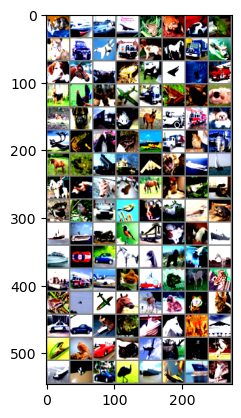

GroundTruth:  cat   ship  ship  plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
net = Net()
Path= f"/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_l5cifar10_cnn.pt"
net.load_state_dict(torch.load(Path, weights_only=True))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Predicted:  frog  ship  ship  ship 
Accuracy of the network on the 10000 test images: 46 %


In [9]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 86.9 %
Accuracy for class: frog  is 95.8 %
Accuracy for class: horse is 93.4 %
Accuracy for class: ship  is 96.2 %
Accuracy for class: truck is 94.5 %
